pm_2_5           float64
day                int64
month              int64
year               int64
season_rainy       int32
season_summer      int32
season_winter      int32
is_holiday         int32
dtype: object


,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(1047, 8)"
5,Transformed data shape,"(1047, 8)"
6,Transformed train set shape,"(1032, 8)"
7,Transformed test set shape,"(15, 8)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-11-28,0.8942,0.8344,1.1228,1.3292,0.2881,0.2854,-0.6801
1,2024-12-13,1.0671,0.9522,1.3481,1.5239,0.3883,0.3397,-0.2420
2,2024-12-28,1.4517,1.3088,1.8337,2.0953,0.3324,0.3797,-0.9018
Mean,NaT,1.1377,1.0318,1.4349,1.6494,0.3363,0.3349,-0.6080
SD,NaT,0.2330,0.2017,0.2966,0.3251,0.0410,0.0386,0.2742


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-11-28,0.6446,0.6384,0.8094,1.0171,0.2420,0.2021,0.0163
1,2024-12-13,0.9290,0.8918,1.1736,1.4272,0.3647,0.2945,-0.0894
2,2024-12-28,0.9030,0.8077,1.1405,1.2930,0.2528,0.2360,0.2758
Mean,NaT,0.8255,0.7793,1.0412,1.2458,0.2865,0.2442,0.0675
SD,NaT,0.1284,0.1053,0.1644,0.1707,0.0555,0.0382,0.1534


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   44.8s finished


Forecast:
               y_pred
2025-01-28  12.725655
2025-01-29  17.380584
2025-01-30  18.470085
2025-01-31  18.936253
2025-02-01  19.000383
2025-02-02  19.431375
2025-02-03  18.378416
2025-02-04  18.335828
2025-02-05  18.859476
2025-02-06  18.702971
2025-02-07  19.249625
2025-02-08  19.246029
2025-02-09  19.496545
2025-02-10  17.563391
2025-02-11  18.659916


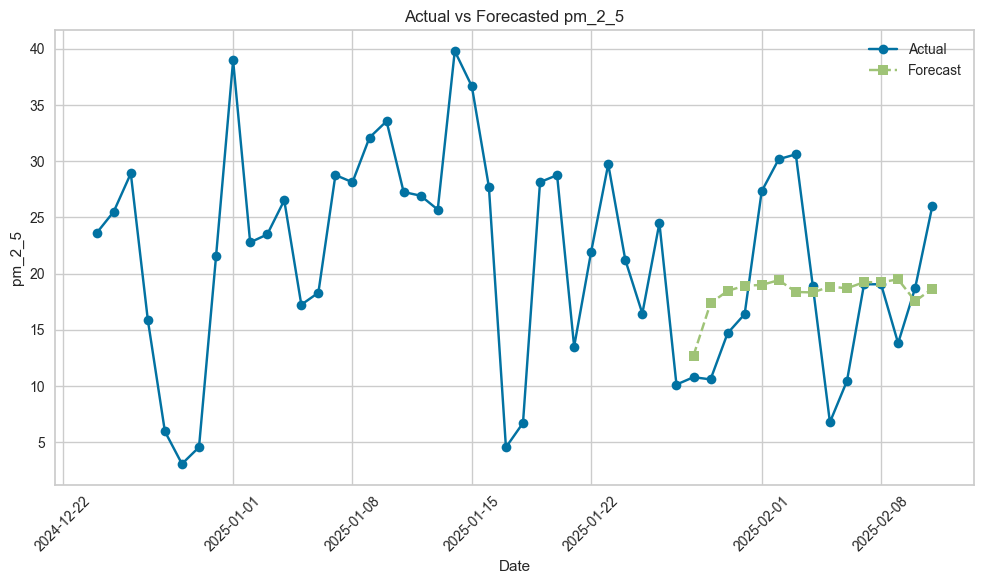

In [58]:
from pycaret.time_series import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.utils.time_series import clean_time_index
import holidays
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv("daily_csv/export-jsps014-1d.csv", parse_dates=["timestamp"], index_col="timestamp")
df = df.drop(columns=["Unnamed: 0"], errors='ignore')

# ลบ index ที่ซ้ำกันและตั้งค่าความถี่เป็นรายวัน
df = df[~df.index.duplicated(keep="last")]
df = df.interpolate()
df = df.asfreq("D")

# กำหนดเกณฑ์สำหรับค่า pm_2_5
df = df[(df['pm_2_5'] >= 0) & (df['pm_2_5'] <= 50)]

# ใช้เฉพาะคอลัมน์ที่ต้องการ
df = df[['pm_2_5']]  # ใช้แค่ pm_2_5 สำหรับการทำนาย
df = clean_time_index(data=df, freq="D")

# เพิ่มฟีเจอร์ วัน, เดือน, ปี
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year

# เพิ่มฟีเจอร์ "ฤดูกาล" ของประเทศไทย
def get_thai_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 15, 8, 9, 10]:
        return 'rainy'
    else:
        return 'winter'

df['season'] = df['month'].apply(get_thai_season)

# One-hot encoding สำหรับฤดูกาล
df = pd.get_dummies(df, columns=['season'], prefix='season')

# แปลง PeriodIndex เป็น DatetimeIndex เพื่อใช้กับ holidays
df.index = df.index.to_timestamp()

# เพิ่มฟีเจอร์ "วันหยุด" ของประเทศไทย
thai_holidays = holidays.TH(years=df.index.year.unique())
df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in thai_holidays else 0)

# แปลง DatetimeIndex กลับเป็น PeriodIndex
df.index = df.index.to_period('D')

# แปลงประเภทข้อมูลของคอลัมน์ให้เป็นตัวเลข
df['is_holiday'] = df['is_holiday'].astype(int)
df['season_summer'] = df['season_summer'].astype(int)
df['season_rainy'] = df['season_rainy'].astype(int)
df['season_winter'] = df['season_winter'].astype(int)


# แบ่งข้อมูลเป็น train set และ test set
train_size = len(df) - 15
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# เติมค่าหายไปใน train set
train_df = train_df.fillna(train_df.mean())

# แปลงข้อมูลด้วย Box-Cox Transformation
train_df['pm_2_5'], lambda_ = boxcox(train_df['pm_2_5'] + 1)  # +1 เพื่อหลีกเลี่ยงค่าติดลบ

# ตรวจสอบประเภทข้อมูลของ train_df
print(train_df.dtypes)

# ฟีเจอร์ที่ใช้ในโมเดล
features = ['day', 'month', 'year', 'is_holiday', 'season_summer', 'season_rainy', 'season_winter']
X_test = test_df[features]

# ตั้งค่า PyCaret
exp = TSForecastingExperiment()
exp.setup(data=train_df, target='pm_2_5', session_id=123, numeric_imputation_target="mean", fh=15, use_gpu=True, seasonal_period=12)

# สร้างโมเดล ARIMA ด้วย Hyperparameters ที่ปรับแล้ว
model = exp.create_model('arima', order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))#,
model = exp.tune_model(model)
model = exp.finalize_model(model)

# ทำนายค่า pm_2_5
forecast = exp.predict_model(model, fh=15, X=test_df.drop(columns="pm_2_5"))

# แปลงค่าทำนายกลับด้วย inverse_boxcox
forecast['y_pred'] = inv_boxcox(forecast['y_pred'], lambda_) - 1

# ปรับค่าทำนายให้ไม่เป็นลบ
forecast['y_pred'] = np.maximum(forecast['y_pred'], 0)

# แสดงผลลัพธ์
print("Forecast:")
print(forecast)

# แก้ไขการพล็อตกราฟเปรียบเทียบค่าจริงกับค่าทำนาย
plt.figure(figsize=(10, 6))
plt.plot(df.index[-50:].to_timestamp(), df['pm_2_5'][-50:], label='Actual', marker='o')
plt.plot(forecast.index.to_timestamp(), forecast['y_pred'], label='Forecast', marker='s', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('pm_2_5')
plt.title('Actual vs Forecasted pm_2_5')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [60]:
print(test_df)

               pm_2_5  day  month  year  season_rainy  season_summer  \
2025-01-28  10.800574   28      1  2025             0              0   
2025-01-29  10.605639   29      1  2025             0              0   
2025-01-30  14.708435   30      1  2025             0              0   
2025-01-31  16.408323   31      1  2025             0              0   
2025-02-01  27.336896    1      2  2025             0              0   
2025-02-02  30.186564    2      2  2025             0              0   
2025-02-03  30.616034    3      2  2025             0              0   
2025-02-04  18.877155    4      2  2025             0              0   
2025-02-05   6.793629    5      2  2025             0              0   
2025-02-06  10.463530    6      2  2025             0              0   
2025-02-07  19.059025    7      2  2025             0              0   
2025-02-08  19.064854    8      2  2025             0              0   
2025-02-09  13.824501    9      2  2025             0           

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ดึงค่าจริงจาก test_df
actual = test_df['pm_2_5']

# ดึงค่าทำนายจาก forecast
predicted = forecast['y_pred']

# คำนวณ MAE
mae = mean_absolute_error(actual, predicted)

# คำนวณ MSE
mse = mean_squared_error(actual, predicted)

# คำนวณ RMSE
rmse = np.sqrt(mse)

# คำนวณ MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(actual, predicted)

# คำนวณ R²
r2 = r2_score(actual, predicted)

# คำนวณความแม่นยำ (Accuracy)
mean_actual = np.mean(actual)
accuracy = (1 - (mae / mean_actual)) * 100

# แสดงผลลัพธ์
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(r2)
print(f"R² (ความแม่นยำ): {r2 * 100:.2f}%")
print(f"ความแม่นยำ (Accuracy): {accuracy:.2f}%")

MAE: 5.4474
MSE: 47.0706
RMSE: 6.8608
MAPE: 37.70%
0.09595384725230871
R² (ความแม่นยำ): 9.60%
ความแม่นยำ (Accuracy): 70.12%
